<a href="https://colab.research.google.com/github/eleubner02/01-Stat-Arb-Pairs-Trading/blob/feat%2Fpair-selection/notebooks/pairs_trading_analysis_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
stockA = 'PEP'
stockB = 'KO'

data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')

/tmp/ipython-input-308995636.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


<Axes: xlabel='Date'>

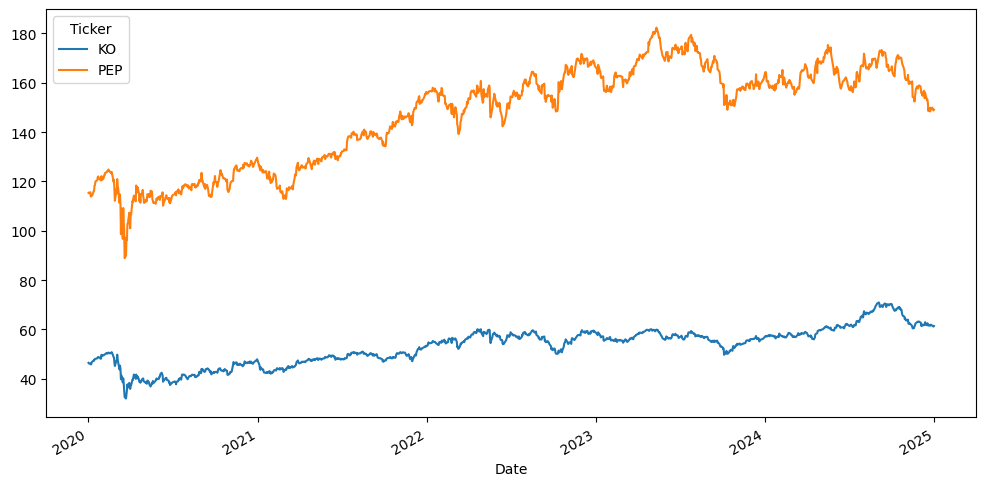

In [3]:
data['Close'].plot(figsize=(12,6))

Next, I will perform the Engle-Granger test to check for cointegration. This is critical because a stationary spread is required for a mean-reverting strategy to be viable.

In [4]:
import statsmodels.api as sm

In [5]:
test_statistic, p_value, critical_values = sm.tsa.stattools.coint(data['Close'][stockA], data['Close'][stockB], trend='c', method='aeg', maxlag=None, autolag='aic', return_results=None)

print(f"Cointegration Test Results:")
print(f"  Test Statistic: {test_statistic}")
print(f"  P-value: {p_value}")
print(f"  Critical Values (1%, 5%, 10%): {critical_values}")

if p_value < 0.05:
    print("\nBased on the p-value, we can reject the null hypothesis and conclude that ", stockA, " and ", stockB, " are likely cointegrated.")
else:
    print("\nBased on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that ", stockA, " and ", stockB, " are cointegrated.")

Cointegration Test Results:
  Test Statistic: -2.1135913833120323
  P-value: 0.46926475174655546
  Critical Values (1%, 5%, 10%): [-3.90517395 -3.34099518 -3.04782579]

Based on the p-value, we cannot reject the null hypothesis and there is not enough evidence to conclude that  PEP  and  KO  are cointegrated.


### Cointegration Test Analysis

The Engle-Granger test resulted in a p-value of 0.469. The null hypothesis for this test is that the two series are not cointegrated. Since our p-value (0.469) is significantly greater than the standard significance level of 0.05, we fail to reject the null hypothesis.

**Conclusion:** There is no statistical evidence in this dataset to suggest that PEP and KO are cointegrated. Therefore, they are not a suitable pair for this pairs trading strategy.

Since PEP-KO failed cointegration, let's systematically find a better pair by iterating through a promising screening universe.

## Systematic Cointegration Screening

In [6]:
screening_universe = {
    # Near-identical ETFs (highest probability)
    'gold_etfs': ['GLD', 'IAU'],
    'silver_etfs': ['SLV', 'SIVR'],

    # Sector ETFs
    'financials': ['XLF', 'KBE'],
    'energy': ['XLE', 'XOP'],

    # Classic pairs
    'major_banks': ['JPM', 'BAC'],
    'energy_majors': ['XOM', 'CVX'],
    'airlines': ['DAL', 'UAL', 'LUV', 'AAL'],
    'retail': ['WMT', 'TGT'],
}

# Download data for all tickers
all_tickers = []
for category_tickers in screening_universe.values():
    all_tickers.extend(category_tickers)
all_tickers = list(set(all_tickers))  # Remove duplicates

print(f"\nDownloading data for {len(all_tickers)} tickers...")
all_data = yf.download(all_tickers, start='2020-01-01', end='2025-01-01', progress=False)['Close']

# Store results
cointegration_results = []

# Test each category
for category, tickers in screening_universe.items():
    print(f"\nTesting {category}...")

    # Generate all pairs within category
    from itertools import combinations
    pairs = list(combinations(tickers, 2))

    for ticker1, ticker2 in pairs:
        try:
            # Get price series
            series1 = all_data[ticker1].dropna()
            series2 = all_data[ticker2].dropna()

            # Find common dates
            common_dates = series1.index.intersection(series2.index)
            if len(common_dates) < 252:  # Need at least 1 year
                continue

            # Align series
            s1 = series1[common_dates]
            s2 = series2[common_dates]

            # Run cointegration test
            test_stat, p_value, crit_values = sm.tsa.stattools.coint(s1, s2)

            # Store result
            cointegration_results.append({
                'pair': f"{ticker1}-{ticker2}",
                'ticker1': ticker1,
                'ticker2': ticker2,
                'category': category,
                'p_value': p_value,
                'test_stat': test_stat,
                'num_days': len(common_dates)
            })

            # Print if significant
            if p_value < 0.05:
                print(f"  ✓ Found cointegrated pair: {ticker1}-{ticker2} (p={p_value:.4f})")

        except Exception as e:
            print(f"  Error with {ticker1}-{ticker2}: {str(e)}")
            continue

# Create results dataframe and sort by p-value
results_df = pd.DataFrame(cointegration_results)
results_df = results_df.sort_values('p_value').reset_index(drop=True)

print("\n" + "-"*60)
print("TOP 10 CANDIDATES (sorted by p-value):")
print("-"*60)
print(results_df[['pair', 'category', 'p_value', 'num_days']].head(10))

# Select the best pair
if len(results_df[results_df['p_value'] < 0.05]) > 0:
    best_pair = results_df.iloc[0]
    print("\n" + "="*60)
    print(f"SELECTED PAIR: {best_pair['ticker1']} - {best_pair['ticker2']}")
    print(f"Category: {best_pair['category']}")
    print(f"P-value: {best_pair['p_value']:.4f}")
    print(f"Days of data: {best_pair['num_days']}")
    print("="*60)

    # Update your variables for the rest of the notebook
    stockA = best_pair['ticker1']
    stockB = best_pair['ticker2']

    # Re-download just this pair's data for consistency
    data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
else:
    print("\nNo significant cointegrated pairs found.")

/tmp/ipython-input-900582721.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  all_data = yf.download(all_tickers, start='2020-01-01', end='2025-01-01', progress=False)['Close']



Testing gold_etfs...

Testing silver_etfs...

Testing financials...

Testing energy...

Testing major_banks...

Testing energy_majors...

Testing airlines...

Testing retail...

------------------------------------------------------------
TOP 10 CANDIDATES (sorted by p-value):
------------------------------------------------------------
       pair       category   p_value  num_days
0   LUV-AAL       airlines  0.062487      1258
1   DAL-UAL       airlines  0.378506      1258
2   XOM-CVX  energy_majors  0.385613      1258
3   XLE-XOP         energy  0.456367      1258
4   GLD-IAU      gold_etfs  0.719782      1258
5   DAL-LUV       airlines  0.742016      1258
6  SLV-SIVR    silver_etfs  0.772771      1258
7   XLF-KBE     financials  0.801877      1258
8   UAL-LUV       airlines  0.853797      1258
9   DAL-AAL       airlines  0.873281      1258

No significant cointegrated pairs found.


While we still fall short of our desired significance level (0.05), the airline stock pair LUV-AAL shows a promising p-value of about 0.06. We also know airlines are economically linked through:

*   Fuel Costs
*   Regulatory Environment
*   Consumer demand patterns

Therefore, we have decent evidence of cointegration and economic sense for a pairs trading strategy, so our analysis will proceed with LUV-AAL.

# Z-Score

While the cointegration test was our permission to trade, the z-score serves as our signal to trade. The z-score is a normalized measure, which coupled with thresholds, tells us when we are far enough from the mean spread to execute our strategy.

/tmp/ipython-input-1409529303.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')
[*********************100%***********************]  2 of 2 completed


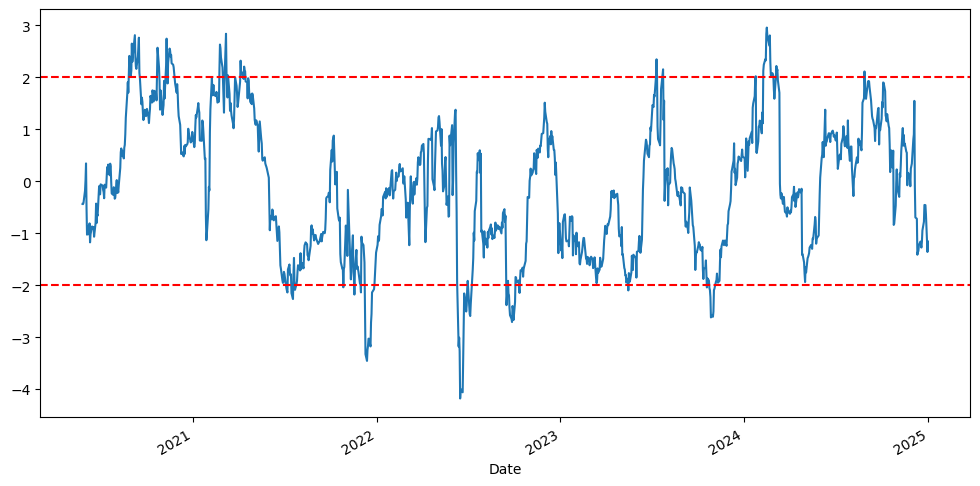

In [10]:
# Updating variables with our chosen stocks LUV (Southwest Airlines) and AAL (American Airlines)

stockA = 'LUV'
stockB = 'AAL'

data = yf.download([stockA, stockB], start='2020-01-01', end='2025-01-01')

spread = data['Close'][stockA] - data['Close'][stockB]

# z-score function. .shift(1) is crucial because it prevents lookahead bias by only focusing on data before a given date
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

z_score = zscore(spread, 100)

upper_threshold = 2.0
lower_threshold = -upper_threshold

ax = z_score.plot(figsize=(12,6))
ax.axhline(upper_threshold, color='r', linestyle='--')
ax.axhline(lower_threshold, color='r', linestyle='--')

# Identify dates where the z-score crosses the thresholds
upper_crossings = z_score[z_score > upper_threshold].index
lower_crossings = z_score[z_score < lower_threshold].index

# print("\nDates when z-score crosses the upper threshold:")
# print(upper_crossings)

# print("\nDates when z-score crosses the lower threshold:")
# print(lower_crossings)

The above z-score visualization is powerful because it confirms the mean-reverting property of the spread.

# Backtesting Engine



**Description:**
This feature implements a vectorized backtesting engine to simulate the performance of the statistical arbitrage pairs trading strategy. It iterates through historical price data on a daily basis, executes trades based on z-score signals, and tracks the portfolio's mark-to-market value over time.

**Core Logic:**
The engine operates on a daily loop with the following logic:
1.  **Initialization:** The backtest begins with a predefined starting capital and a 'FLAT' (no-risk) position.
2.  **Signal Generation:** Each day, it calculates the z-score of the pair's spread. If the z-score crosses a predefined entry threshold (e.g., >2.0 or <-2.0), a trade signal is generated.
3.  **Trade Execution:** On a signal, if no position is currently held, the engine simulates a trade. It allocates a fixed amount of capital (e.g., $10,000) to both the long and short legs of the pair, calculates the number of shares, and updates the cash balance. The position state is updated to 'LONG' or 'SHORT'.
4.  **Position Closing:** If a position is open and the z-score reverts toward the mean (e.g., `abs(z-score) < 0.5`), the position is closed. All holdings are sold at the current market price, cash is updated, and the position is reset to 'FLAT'.
5.  **Daily Mark-to-Market:** At the end of every day, the engine calculates the total portfolio value by summing the current cash balance and the market value of any shares held. This daily value is stored to generate an equity curve.

In [11]:
# 1. Initialization (Run this cell once)
position = 0                # 0 for FLAT, 1 for LONG, -1 for SHORT
initial_capital = 100000.0
cash = initial_capital
trade_size = 10000.0        # Allocate $10,000 to each side of the pair trade

# State variables for our holdings
shares_A = 0
shares_B = 0 # Will be negative when we are short

# History tracking
portfolio_value_history = []

# Thresholds
ENTRY_THRESHOLD = upper_threshold
EXIT_THRESHOLD = 0.5 # Exit when z-score gets back near zero

In [12]:
# Objective: Build the skeleton of your backtesting engine. This is about structure, not perfect execution yet.
# Tasks: In a new section of your notebook, write the pseudo-code or initial Python code for a simple backtester loop. It should:
# Create a loop that iterates through your price data day by day.
# Inside the loop, use if/elif statements to check if the z-score crosses your thresholds.
# Create variables to track your state (e.g., position [Long, Short, or Flat], cash, portfolio_value).
# Commit to GitHub: "Scaffolded basic backtester loop logic."for date in data['Close']:


# 2. Main Backtesting Loop (The Core Logic)
# We iterate through the z_score's index, which starts after the initial rolling window period
for date in z_score.index:

    # Get the current day's z-score and prices. This is crucial.
    current_z = z_score[date]
    price_A = data['Close'][stockA][date]
    price_B = data['Close'][stockB][date]

    # --- TRADING LOGIC ---

    # Case 1: Enter a LONG position on the spread
    # (Spread is cheap, we buy it expecting it to rise)
    if current_z < -ENTRY_THRESHOLD and position == 0:
        position = 1

        # Calculate how many shares to trade
        shares_A = trade_size / price_A
        shares_B = -(trade_size / price_B) # Negative for shorting

        # Update cash
        cash -= (shares_A * price_A) # Cash out to buy A
        cash -= (shares_B * price_B) # Cash in from shorting B (shares_B is negative)

        print(f"{date.date()}: Entering LONG position. Buying {shares_A:.2f} of {stockA}, Shorting {-shares_B:.2f} of {stockB}.")

    # Case 2: Enter a SHORT position on the spread
    # (Spread is expensive, we short it expecting it to fall)
    elif current_z > ENTRY_THRESHOLD and position == 0:
        position = -1

        # Calculate how many shares to trade
        shares_A = -(trade_size / price_A) # Negative for shorting
        shares_B = trade_size / price_B

        # Update cash
        cash -= (shares_A * price_A) # Cash in from shorting A
        cash -= (shares_B * price_B) # Cash out to buy B

        print(f"{date.date()}: Entering SHORT position. Shorting {-shares_A:.2f} of {stockA}, Buying {shares_B:.2f} of {stockB}.")

    # Case 3: Exit any open position
    # We exit if we have a position AND the z-score has returned near the mean
    elif abs(current_z) < EXIT_THRESHOLD and position != 0:

        # Update cash by "closing" our positions at current prices
        cash += (shares_A * price_A) + (shares_B * price_B)

        print(f"{date.date()}: Exiting position. Final cash from trade: {cash:.2f}")

        # Reset state variables
        position = 0
        shares_A = 0
        shares_B = 0

    # --- PORTFOLIO UPDATING (This happens every day, regardless of trades) ---

    # Calculate the current market value of our holdings
    holdings_value = (shares_A * price_A) + (shares_B * price_B)

    # Calculate total portfolio value
    current_portfolio_value = cash + holdings_value

    # Store it for later plotting
    portfolio_value_history.append(current_portfolio_value)


2020-08-27: Entering SHORT position. Shorting 282.65 of LUV, Buying 753.01 of AAL.
2020-12-14: Exiting position. Final cash from trade: 100554.06
2021-02-23: Entering SHORT position. Shorting 187.62 of LUV, Buying 484.03 of AAL.
2021-05-19: Exiting position. Final cash from trade: 101025.12
2021-07-06: Entering LONG position. Buying 203.24 of LUV, Shorting 475.96 of AAL.
2021-09-23: Exiting position. Final cash from trade: 101069.83
2021-10-27: Entering LONG position. Buying 228.51 of LUV, Shorting 525.49 of AAL.
2021-11-05: Exiting position. Final cash from trade: 100819.10
2021-11-18: Entering LONG position. Buying 229.50 of LUV, Shorting 515.73 of AAL.
2022-01-14: Exiting position. Final cash from trade: 101164.65
2022-06-13: Entering LONG position. Buying 282.88 of LUV, Shorting 750.75 of AAL.
2022-07-18: Exiting position. Final cash from trade: 100868.08
2022-09-16: Entering LONG position. Buying 306.41 of LUV, Shorting 727.27 of AAL.
2022-10-28: Exiting position. Final cash from 

**Next Steps:**
- Plot the `portfolio_value_history` to visualize the strategy's equity curve.
- Calculate key performance metrics (e.g., Sharpe Ratio, Total Return, Max Drawdown)

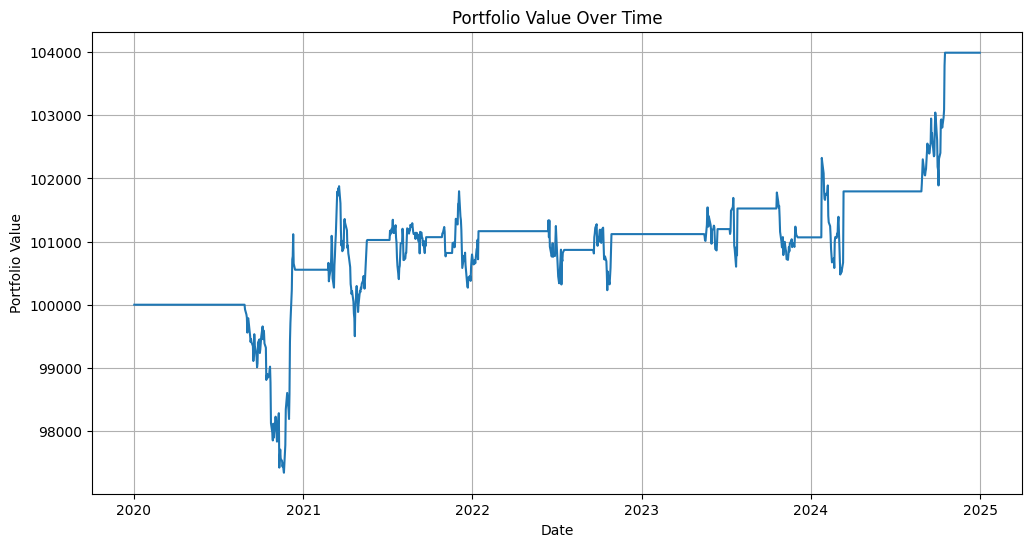

In [13]:
import matplotlib.pyplot as plt

# The portfolio_value_history list corresponds to the dates in the z_score index,
# because we appended a value to it for each date in the z_score loop.
plt.figure(figsize=(12, 6))
plt.plot(z_score.index, portfolio_value_history)
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()